In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

#### 读取特征/标签的DataFrame

In [2]:
def get_stage_feature_label(stage):
    # 文件路径
    feature_path = f'K:\\Sichuan\\H5\\resampled_feature_data\\resampled_feature_{stage}.csv'
    label_path = f'K:\\Sichuan\\H5\\resampled_label_data\\resampled_label_{stage}.csv'
    
    feature_df = pd.read_csv(feature_path, index_col=0)
    label_df = pd.read_csv(label_path, index_col=0)
    
    feature_df.index = pd.to_datetime(feature_df.index, format="%Y-%m-%d %H:%M:%S") # 压裂数据
    label_df.index = pd.to_datetime(label_df.index, format="%Y-%m-%d %H:%M:%S") # 微地震散点数据

    return (feature_df, label_df)

In [3]:
a, b = get_stage_feature_label(5)
display(a, b)

,pressure,rate,total_rate,prop,total_prop
time,,,,,
2017-03-22 07:59:25,40.31,0.000,0.00,0.0,0.00
2017-03-22 08:00:25,45.80,0.599,0.48,0.0,0.00
2017-03-22 08:01:25,53.19,1.188,1.34,0.0,0.00
2017-03-22 08:02:25,57.29,1.210,2.54,0.0,0.00
2017-03-22 08:03:25,61.45,1.791,4.11,0.0,0.00
...,...,...,...,...,...
2017-03-22 10:43:25,51.04,0.000,1843.92,0.0,120.78
2017-03-22 10:44:25,50.97,0.000,1843.92,0.0,120.78
2017-03-22 10:45:25,50.91,0.000,1843.92,0.0,120.78


,distance
time,
2017-03-22 07:59:25,0.000000
2017-03-22 08:00:25,7.504994
2017-03-22 08:01:25,15.009987
2017-03-22 08:02:25,22.514981
2017-03-22 08:03:25,30.019975
...,...
2017-03-22 10:43:25,373.624999
2017-03-22 10:44:25,373.624999
2017-03-22 10:45:25,373.624999


In [3]:
# 跳过32, 因为32段有问题，还没压裂就有地震！跳过45，因为45两个对不上！
stage_list = list(range(32)) + list(range(33, 45)) + list(range(46, 73))

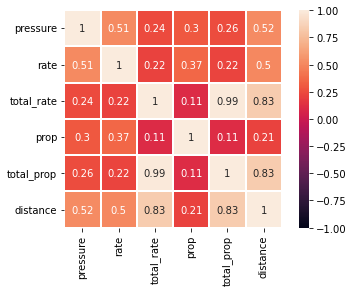

In [557]:
import seaborn as sns
ff, ll = get_stage_feature_label(65)
fl = pd.merge(ff, ll, how='outer', on=ff.index)
del fl['key_0']
fl = fl.apply(lambda x: x.astype(float))
corr = fl.corr(method='spearman')
sns.heatmap(corr,linewidths=0.1,vmax=1.0,vmin=-1.0, square=True,linecolor='white',annot=True)
plt.savefig(f'K:\\Sichuan\\H5\\heat_map', 
            dpi=300, bbox_inches="tight", pad_inches=0.1)

#### 步骤：在每个stage上单独使用时间窗划分X,Y并创建dataset，然后再使用ConcatDataset拼接成一个完整的dataset
可调参数：时间窗、批大小、隐藏层数目、学习率、、、训练集划分、epoch数

In [4]:
import torch
import torch.nn as nn
from torch import optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset
import time
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [92]:
# ----------再每个段上单独划分成训练集----------

time_window = 10    # 时间步长为多少
def make_stage_dataset(stage, time_window=time_window):
    # 载入原始输入并转换为 numpy 数组
    feature_df, label_df = get_stage_feature_label(stage)
#     feature_df['injectivity'] = feature_df['rate'] / feature_df['pressure']    # 增加 injectivity 作为特征
    feature_array = np.array(feature_df)
    label_array = np.array(label_df)
    
    # 数据标准化（0-1区间）
    scaler = MinMaxScaler(feature_range=(0, 1))
    feature_array = scaler.fit_transform(feature_array)
    label_array = scaler.fit_transform(label_array)
    
    # 【optional: 是否需要过去的数据】
    xy_array = np.concatenate((feature_array, label_array), axis=1)
    
    # 采用时间窗划分数组
    length = label_array.shape[0]
    x_list = []
    y_list = []
    for i in range(length):
        end_idx = i + time_window
        if end_idx > length:             # 【修改了】
            break
        x_array = feature_array[i:end_idx]     # 【修改了】
        y_array = label_array[end_idx-1]    # 【修改了】
        x_list.append(x_array)
        y_list.append(y_array)
    
    # 转化为 tensor, 用 TensorDataset 直接转化成数据集（一个段的）
    x_tensor = torch.tensor(np.array(x_list), dtype=torch.float32)
    y_tensor = torch.tensor(np.array(y_list), dtype=torch.float32).view(-1, 1, 1)
    
    train_stage_data = TensorDataset(x_tensor, y_tensor)
    return train_stage_data

In [93]:
# 按照段划分训练集和测试集（随机划分）
from random import sample
from math import ceil

frac_number = 0.8    # 取 ?% 作为训练集
train_stage_number = ceil(len(stage_list) * frac_number)
train_stage_list = sample(stage_list, train_stage_number)             # 训练集段号
test_stage_list = list(set(stage_list) - set(train_stage_list))       # 测试集段号
print(f'training stage number: {len(train_stage_list)}, \
testing stage number: {len(test_stage_list)}\ntesting stages: {test_stage_list}')

# 把各段的数据集拼接成整体的数据集
whole_train_dataset_list = []
whole_test_dataset_list = []

for train_stage in train_stage_list:
    train_stage_dataset = make_stage_dataset(train_stage)
    whole_train_dataset_list.append(train_stage_dataset)

for test_stage in test_stage_list:
    test_stage_dataset = make_stage_dataset(test_stage)
    whole_test_dataset_list.append(test_stage_dataset)
    
whole_train_dataset = ConcatDataset(whole_train_dataset_list)
whole_test_dataset = ConcatDataset(whole_test_dataset_list)
print('-'*50)
print(f'total training samples: {len(whole_train_dataset)}')
print(f'total testing samples: {len(whole_test_dataset)}')

training stage number: 57, testing stage number: 14
testing stages: [64, 66, 35, 68, 38, 7, 10, 42, 48, 50, 56, 27, 62, 31]
--------------------------------------------------
total training samples: 10412
total testing samples: 2498


In [94]:
whole_test_dataset[0]

(tensor([[4.2021e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [4.5907e-01, 1.2206e-01, 2.9861e-04, 0.0000e+00, 0.0000e+00],
         [4.8595e-01, 1.6979e-01, 1.3766e-03, 0.0000e+00, 0.0000e+00],
         [5.0745e-01, 1.7014e-01, 2.5913e-03, 0.0000e+00, 0.0000e+00],
         [5.2334e-01, 1.7071e-01, 3.8060e-03, 0.0000e+00, 0.0000e+00],
         [5.3458e-01, 1.6957e-01, 5.0206e-03, 0.0000e+00, 0.0000e+00],
         [5.3910e-01, 1.7007e-01, 6.2353e-03, 0.0000e+00, 0.0000e+00],
         [5.4619e-01, 1.7050e-01, 7.4500e-03, 0.0000e+00, 0.0000e+00],
         [5.5095e-01, 1.6993e-01, 8.6646e-03, 0.0000e+00, 0.0000e+00],
         [5.5193e-01, 1.7050e-01, 9.8793e-03, 0.0000e+00, 0.0000e+00]]),
 tensor([[0.2017]]))

#### 载入数据，利用LSTM进行训练
input tensor (batch_size, sequence length, input_size)   
output tensor (batch_size, sequence length, hidden_size)   
h0, c0 tensor (num_layers, batch_size, hidden_size)

In [82]:
batch_size = 16
train_loader = DataLoader(dataset=whole_train_dataset, shuffle=False, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(dataset=whole_test_dataset, shuffle=False, batch_size=batch_size, drop_last=True)

In [83]:
class my_LSTM(nn.Module):
    def __init__(self, hidden_size):
        super(my_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=1)
    
    def forward(self, x):
        h0 = torch.zeros(2, x.shape[0], self.hidden_size)
        c0 = torch.zeros(2, x.shape[0], self.hidden_size)
        lstm_out, _ = self.lstm(x, (h0,c0))
        prediction = self.fc(lstm_out[:,-1,:]).view(x.shape[0], 1, 1)
#         prediction = self.fc(lstm_out)[:,-1,:]
        return prediction

In [84]:
# 超参数设置
hidden_neurons = 8
learning_rate = 0.001

model = my_LSTM(hidden_neurons)
model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [85]:
epochs = 51
# 记录 loss
batch_loss_list = []
epoch_loss_list = []
test_loss_list = []

n_batches = len(train_loader)
n_test_batches = len(test_loader)

begin_time = time.time()

for epoch in range(epochs):
    acc_loss = 0.0
    acc_test_loss = 0.0
    
    for batch, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        y = y.view(batch_size, 1, 1)
        # 计算误差
        pred = model(x)
        loss = loss_fn(pred, y)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差（每个batch和整个epoch）
        batch_loss_list.append(loss.item())
        acc_loss += loss.item()
    epoch_loss_value = acc_loss / n_batches
    epoch_loss_list.append(epoch_loss_value)
    
    print(f'epoch {epoch+1}: last loss = {loss.item():.5f}, average loss = {epoch_loss_value:.5f}')
    
    with torch.no_grad():
        for test_batch, (test_x, test_y) in enumerate(test_loader):
            test_x = test_x.to(device)
            test_y = test_y.to(device)
            test_y = test_y.view(batch_size, 1, 1)
            
            test_pred = model(test_x)
            test_loss = loss_fn(test_pred, test_y)
            acc_test_loss += test_loss.item()
    test_loss_value = acc_test_loss / n_test_batches
    test_loss_list.append(test_loss_value)
    
    print(f'loss on test: {test_loss_value:.5f}')
    print('*'*50)
            
print(f'Training done in {(time.time()-begin_time):.2f}s')

model_save_path = f'K:\\Sichuan\\H5\\model_save_dict\\smoothed_t{time_window}_batch{batch_size}_\
hidden{hidden_neurons}_loss{test_loss_value:.5f}.pth'
torch.save(model.state_dict(), model_save_path)

print('Model saved.')

epoch 1: last loss = 0.00003, average loss = 0.04379
loss on test: 0.00219
**************************************************
epoch 2: last loss = 0.00006, average loss = 0.00234
loss on test: 0.00218
**************************************************
epoch 3: last loss = 0.00005, average loss = 0.00221
loss on test: 0.00203
**************************************************
epoch 4: last loss = 0.00001, average loss = 0.00206
loss on test: 0.00192
**************************************************
epoch 5: last loss = 0.00001, average loss = 0.00189
loss on test: 0.00179
**************************************************
epoch 6: last loss = 0.00002, average loss = 0.00172
loss on test: 0.00163
**************************************************
epoch 7: last loss = 0.00003, average loss = 0.00156
loss on test: 0.00147
**************************************************
epoch 8: last loss = 0.00004, average loss = 0.00140
loss on test: 0.00128
*******************************************

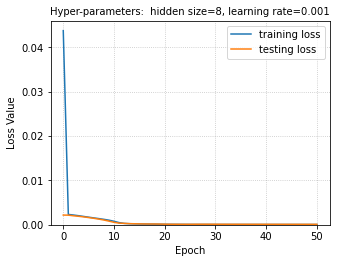

In [86]:
fig, ax = plt.subplots(figsize=(5, 3.75))
ax.plot(epoch_loss_list, label='training loss')
ax.plot(test_loss_list, label='testing loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss Value')
ax.set_ylim(bottom=0)
ax.grid(linestyle=':', c='grey', alpha=0.5)
ax.set_title(f'Hyper-parameters:  hidden size={hidden_neurons}, learning rate={learning_rate}', fontsize=10)
ax.legend()
fig.savefig(f'K:\\Sichuan\\H5\\training_images\\loss--smoothed_t{time_window}_batch{batch_size}_\
hidden{hidden_neurons}_loss{test_loss_value:.5f}.png', 
            dpi=300, bbox_inches="tight", pad_inches=0.1)

#### 对比预测值和真实值

In [87]:
# 在 CPU 上进行评估
device = torch.device('cpu')
model = my_LSTM(hidden_neurons)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

my_LSTM(
  (lstm): LSTM(1, 8, num_layers=2, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

In [88]:
test_predictions = []
with torch.no_grad():
    for test_batch, (test_x, test_y) in enumerate(test_loader):
        test_x = test_x.to(device)
        test_y = test_y.to(device)
        test_y = test_y.view(batch_size, 1, 1)

        test_pred = model(test_x)
        test_predictions.append(test_pred.view(16, 1).numpy())
test_predictions = np.array(test_predictions)
test_predictions = test_predictions.reshape(-1, 1)
test_predictions.shape

(2544, 1)

In [89]:
test_data = []
for test_stage in test_stage_list:
    test_data_temp = make_stage_dataset(test_stage)
    test_data.append(test_data_temp)
test_set = ConcatDataset(test_data)

In [90]:
true_value_list = []
for sample in range(len(test_set)):
    true_value = test_set.__getitem__(sample)[1].item()
    true_value_list.append(true_value)
true_value_list = np.array(true_value_list).reshape(-1, 1)
true_value_list.shape

(2554, 1)

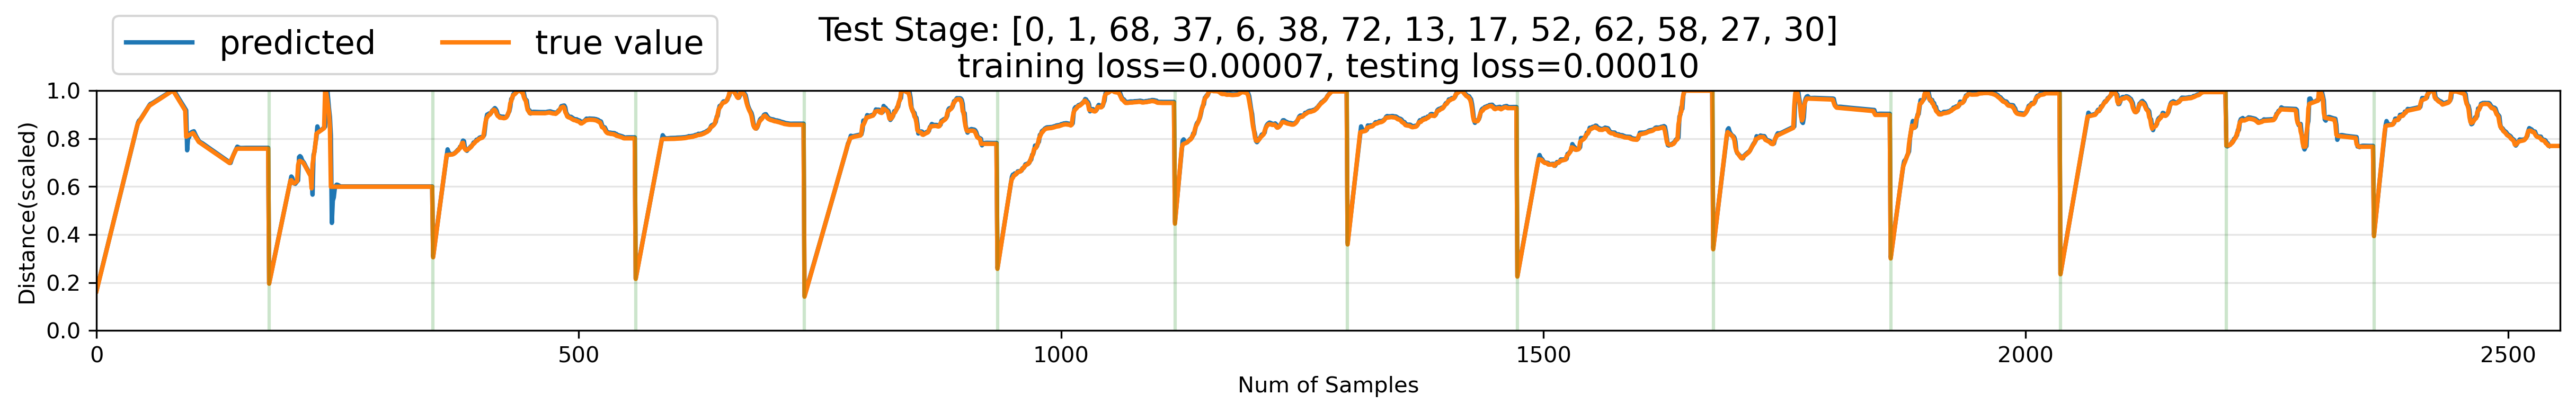

In [91]:
fig, ax = plt.subplots(figsize=(20, 2), dpi=300)
line1, = ax.plot(test_predictions, label='predicted')
line2, = ax.plot(true_value_list, label='true value', linestyle='-')
line1.set_linewidth(2.0)
line2.set_linewidth(2.0)
ax.set_xlabel('Num of Samples')
ax.set_ylabel('Distance(scaled)')
ax.set_ylim(0, 1)
ax.set_xlim(0, len(true_value_list))
acc_pos = 0.0
for stg in test_data[:-1]:
    lgth = len(stg)
    acc_pos += lgth
    ax.vlines(acc_pos, 0, 1, colors='g', linestyles='-', alpha=0.2)
ax.grid(axis='y', linestyle='-', c='grey', alpha=0.2)
ax.set_title(f'Test Stage: {test_stage_list}\n\
training loss={epoch_loss_value:.5f}, testing loss={test_loss_value:.5f}', fontsize=15)
ax.legend(bbox_to_anchor=(0.0,1.0), loc="lower left", ncol=2, fontsize=15)
fig.savefig(f'K:\\Sichuan\\H5\\training_images\\test--smoothed_t{time_window}_batch{batch_size}_\
hidden{hidden_neurons}_loss{test_loss_value:.5f}.png', 
            dpi=300, bbox_inches="tight", pad_inches=0.1)

## *baseline模型*

In [342]:
def make_stage_dataset(stage, time_window=1):
    # 载入原始输入并转换为 numpy 数组
    feature_df, label_df = get_stage_feature_label(stage)
    feature_array = np.array(feature_df)
    label_array = np.array(label_df)
    
    # 数据标准化（0-1区间）
    scaler = MinMaxScaler(feature_range=(0, 1))
    feature_array = scaler.fit_transform(feature_array)
    label_array = scaler.fit_transform(label_array)
    
    # 采用时间窗划分数组
    length = label_array.shape[0]
    x_list = []
    y_list = []
    for i in range(length):
        end_idx = i + time_window
        if end_idx > length:
            break
        x_array = feature_array[i:end_idx]
        y_array = label_array[end_idx-1]
        x_list.append(x_array)
        y_list.append(y_array)
    
    # 转化为 tensor, 用 TensorDataset 直接转化成数据集（一个段的）
    x_tensor = torch.tensor(x_list, dtype=torch.float32)
    y_tensor = torch.tensor(y_list, dtype=torch.float32)
    
    train_stage_data = TensorDataset(x_tensor, y_tensor)
    return train_stage_data

In [343]:
# 按照段划分训练集和测试集（随机划分）
from random import sample
from math import ceil

frac_number = 0.8    # 取 95% 作为训练集
train_stage_number = ceil(len(stage_list) * frac_number)
train_stage_list = sample(stage_list, train_stage_number)             # 训练集段号
test_stage_list = list(set(stage_list) - set(train_stage_list))       # 测试集段号

# 把各段的数据集拼接成整体的数据集
whole_train_dataset_list = []
whole_test_dataset_list = []

for train_stage in train_stage_list:
    train_stage_dataset = make_stage_dataset(train_stage)
    whole_train_dataset_list.append(train_stage_dataset)

for test_stage in test_stage_list:
    test_stage_dataset = make_stage_dataset(test_stage)
    whole_test_dataset_list.append(test_stage_dataset)
    
whole_train_dataset = ConcatDataset(whole_train_dataset_list)
whole_test_dataset = ConcatDataset(whole_test_dataset_list)

In [344]:
train_loader = DataLoader(dataset=whole_train_dataset, shuffle=False, batch_size=16, drop_last=True)
test_loader = DataLoader(dataset=whole_test_dataset, shuffle=False, batch_size=16, drop_last=True)

In [345]:
class linear_regression(nn.Module):
    def __init__(self):
        super(linear_regression, self).__init__()
        self.linear = nn.Linear(5, 1)
    
    def forward(self, x):
        prediction = self.linear(x)
        return prediction

In [360]:
learning_rate = 0.001

model = linear_regression()
model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [377]:
epochs = 51
batch_loss_list = []
epoch_loss_list = []
test_loss_list = []
n_batches = len(train_loader)
n_test_batches = len(test_loader)

begin_time = time.time()

for epoch in range(epochs):
    acc_loss = 0.0
    acc_test_loss = 0.0
    
    for batch, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        y = y.view(16, 1, 1)
        # 计算误差
        pred = model(x)
        loss = loss_fn(pred, y)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差（每个batch和整个epoch）
        batch_loss_list.append(loss.item())
        acc_loss += loss.item()
    epoch_loss_value = acc_loss / n_batches
    epoch_loss_list.append(epoch_loss_value)
    
    print(f'epoch {epoch+1}: last loss = {loss.item():.5f}, average loss = {epoch_loss_value:.5f}')
    
    with torch.no_grad():
        for test_batch, (test_x, test_y) in enumerate(test_loader):
            test_x = test_x.to(device)
            test_y = test_y.to(device)
            test_y = test_y.view(16, 1, 1)
            
            test_pred = model(test_x)
            test_loss = loss_fn(test_pred, test_y)
            acc_test_loss += test_loss.item()
    test_loss_value = acc_test_loss / n_test_batches
    test_loss_list.append(test_loss_value)
    
    print(f'loss on test: {test_loss_value:.5f}')
    print('*'*50)
    
model_save_path = f'K:\\Sichuan\\H5\\model_save_dict\\baseline.pth'
torch.save(model.state_dict(), model_save_path)              
print(f'Training done in {(time.time()-begin_time):.2f}s')

epoch 1: last loss = 0.02410, average loss = 0.02047
loss on test: 0.01935
**************************************************
epoch 2: last loss = 0.02410, average loss = 0.02047
loss on test: 0.01935
**************************************************
epoch 3: last loss = 0.02410, average loss = 0.02047
loss on test: 0.01935
**************************************************
epoch 4: last loss = 0.02410, average loss = 0.02047
loss on test: 0.01935
**************************************************
epoch 5: last loss = 0.02410, average loss = 0.02047
loss on test: 0.01935
**************************************************
epoch 6: last loss = 0.02410, average loss = 0.02047
loss on test: 0.01935
**************************************************
epoch 7: last loss = 0.02410, average loss = 0.02047
loss on test: 0.01935
**************************************************
epoch 8: last loss = 0.02411, average loss = 0.02047
loss on test: 0.01935
*******************************************

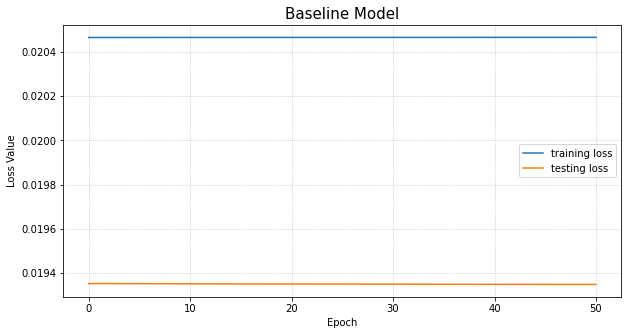

In [378]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(epoch_loss_list, label='training loss')
ax.plot(test_loss_list, label='testing loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss Value')
# ax.set_ylim(0, 0.3)
ax.grid(linestyle=':', c='grey', alpha=0.5)
ax.set_title('Baseline Model', fontsize=15)
ax.legend()
fig.savefig(f'K:\\Sichuan\\H5\\training_images\\baseline_loss.png', 
            dpi=300, bbox_inches="tight", pad_inches=0.1)

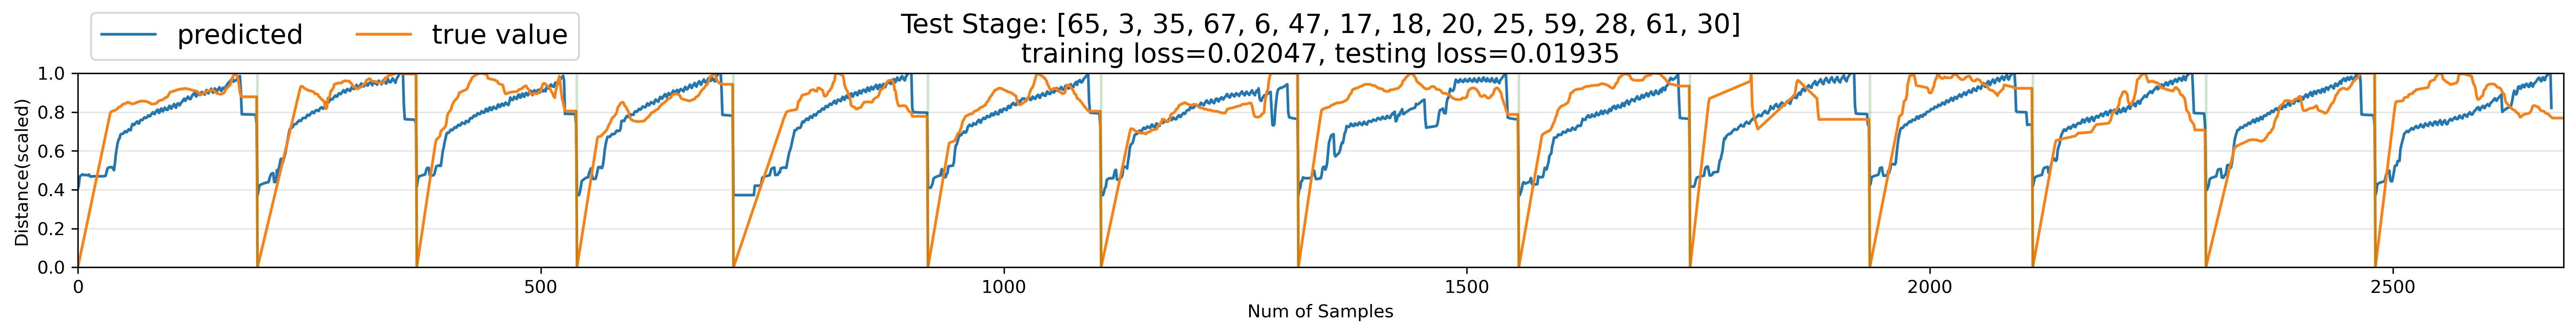

In [381]:
device = torch.device('cpu')
model = linear_regression()
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

test_predictions = []
with torch.no_grad():
    for test_batch, (test_x, test_y) in enumerate(test_loader):
        test_x = test_x.to(device)
        test_y = test_y.to(device)
        test_y = test_y.view(batch_size, 1, 1)

        test_pred = model(test_x)
        test_predictions.append(test_pred.view(16, 1).numpy())
test_predictions = np.array(test_predictions)
test_predictions = test_predictions.reshape(-1, 1)

test_data = []
for test_stage in test_stage_list:
    test_data_temp = make_stage_dataset(test_stage)
    test_data.append(test_data_temp)
test_set = ConcatDataset(test_data)

true_value_list = []
for sample in range(len(test_set)):
    true_value = test_set.__getitem__(sample)[1].item()
    true_value_list.append(true_value)
true_value_list = np.array(true_value_list).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(25,2), dpi=300)
line1, = ax.plot(test_predictions, label='predicted')
line2, = ax.plot(true_value_list, label='true value')

ax.set_xlabel('Num of Samples')
ax.set_ylabel('Distance(scaled)')
ax.set_ylim(0, 1)
ax.set_xlim(0, len(true_value_list))
acc_pos = 0.0
for stg in test_data[:-1]:
    lgth = len(stg)
    acc_pos += lgth
    ax.vlines(acc_pos, 0, 1, colors='g', linestyles='-', alpha=0.2)
ax.grid(axis='y', linestyle='-', c='grey', alpha=0.2)
ax.set_title(f'Test Stage: {test_stage_list}\n\
training loss={epoch_loss_value:.5f}, testing loss={test_loss_value:.5f}', fontsize=15)
ax.legend(bbox_to_anchor=(0.0,1.0), loc="lower left", ncol=2, fontsize=15)
fig.savefig(f'K:\\Sichuan\\H5\\training_images\\baseline_test.png', 
            dpi=300, bbox_inches="tight", pad_inches=0.1)